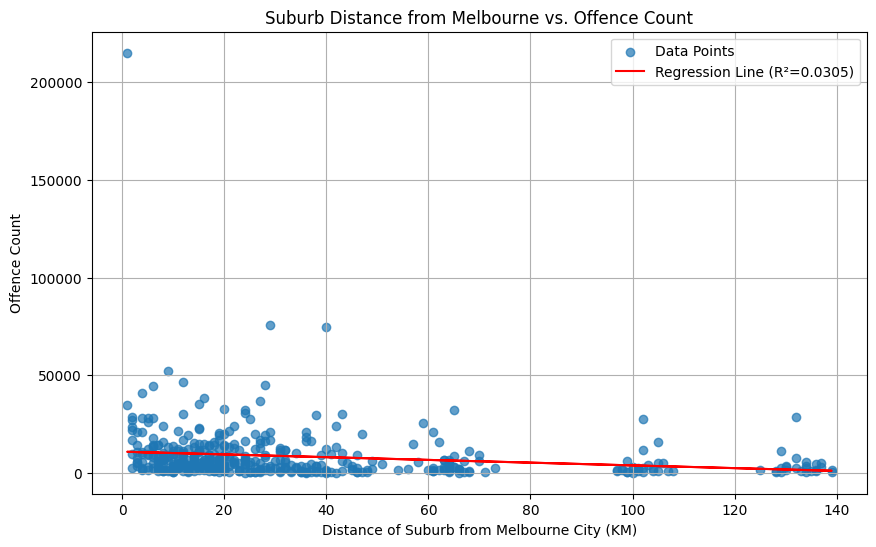

Correlation coefficient between Suburb Distance and Offence Count: -0.1747
Linear regression equation: y = -70.2752x + 10871.5360


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from scipy import stats

def suburb_distance_from_city_vs_offence_count():
    # Load communities data
    cm = pd.read_csv("imputed_data_communities_new.csv")
    cm["Type"] = cm["Community Name"].apply(extract_type)

    suburbs_df = cm[cm["Type"] == "Suburb"].copy()

    # Load drug offences data
    suburb_drug_offences_df = pd.read_excel('LGA Offences.xlsx', sheet_name='Table 03')

    # Standardize suburb names
    suburbs_df['Community Name'] = suburbs_df['Community Name'].str.replace(r' \((Suburb|suburb)\)', '', regex=True).str.strip().str.lower()
    suburb_drug_offences_df['Suburb/Town Name'] = suburb_drug_offences_df['Suburb/Town Name'].str.strip().str.lower()

    # Group by suburb and sum offence counts
    suburb_drug_offenses_grouped = suburb_drug_offences_df.groupby('Suburb/Town Name')['Offence Count'].sum().reset_index()

    suburb = []
    distance_list = []

    # Create data for suburbs and their distances from Melbourne
    for index, suburbs in suburbs_df.iterrows():
        location = suburbs["Location"]
        distance = int(extract_distance(location))

        suburb.append(suburbs["Community Name"])
        distance_list.append(distance)

    distance_df = pd.DataFrame({
        "Community Name": suburb,
        "Distance": distance_list
    })

    # Ensure both DataFrames have lowercase, standardized 'Community Name' columns
    distance_df['Community Name'] = distance_df['Community Name'].str.strip().str.lower()
    suburb_drug_offenses_grouped['Suburb/Town Name'] = suburb_drug_offenses_grouped['Suburb/Town Name'].str.strip().str.lower()

    # Merge distance_df with suburb_drug_offenses_grouped
    merged_df = pd.merge(distance_df, suburb_drug_offenses_grouped, left_on='Community Name', right_on='Suburb/Town Name', how='inner')

    # Drop 'Suburb/Town Name' column after merging
    merged_df = merged_df.drop(columns=['Suburb/Town Name'])

    # Reordering columns for clarity (if necessary)
    merged_df = merged_df[['Community Name', 'Distance', 'Offence Count']]

    # Plot scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(merged_df["Distance"], merged_df['Offence Count'], alpha=0.7, label='Data Points')

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(merged_df["Distance"], merged_df['Offence Count'])
    regression_line = slope * merged_df["Distance"] + intercept
    
    # Plot regression line
    plt.plot(merged_df["Distance"], regression_line, color='red', label=f'Regression Line (R²={r_value**2:.4f})')

    # Plot settings
    plt.title('Suburb Distance from Melbourne vs. Offence Count')
    plt.xlabel('Distance of Suburb from Melbourne City (KM)')
    plt.ylabel('Offence Count')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate correlation coefficient
    correlation = merged_df["Distance"].corr(merged_df['Offence Count'])
    print(f"Correlation coefficient between Suburb Distance and Offence Count: {correlation:.4f}")
    print(f"Linear regression equation: y = {slope:.4f}x + {intercept:.4f}")

    return

def extract_type(name):
    pattern_town = r'\(Suburb|suburb\)'
    if re.findall(pattern_town, name):
        return "Suburb"

def extract_distance(sentence):
    pattern = r'(\d+)km [A-Z]+ of Melbourne'
    var = re.match(pattern, sentence)
    if var:
        return var.group(1)

# Call the function to execute
suburb_distance_from_city_vs_offence_count()


DataFrame saved as 'suburb_analysis.csv'.
    Community Name  Distance  Offence Count  Category
0       abbotsford         3          14185     Urban
1       aberfeldie         8           1383     Urban
2     airport west        12           9533     Urban
3        albanvale        19           3892     Urban
4      albert park         3           5709     Urban
..             ...       ...            ...       ...
446     wonga park        29            878  Suburban
447   wyndham vale        31          10456  Suburban
448      yallambie        15           1462     Urban
449      yarrambat        25            539  Suburban
450     yarraville         7           8620     Urban

[451 rows x 4 columns]


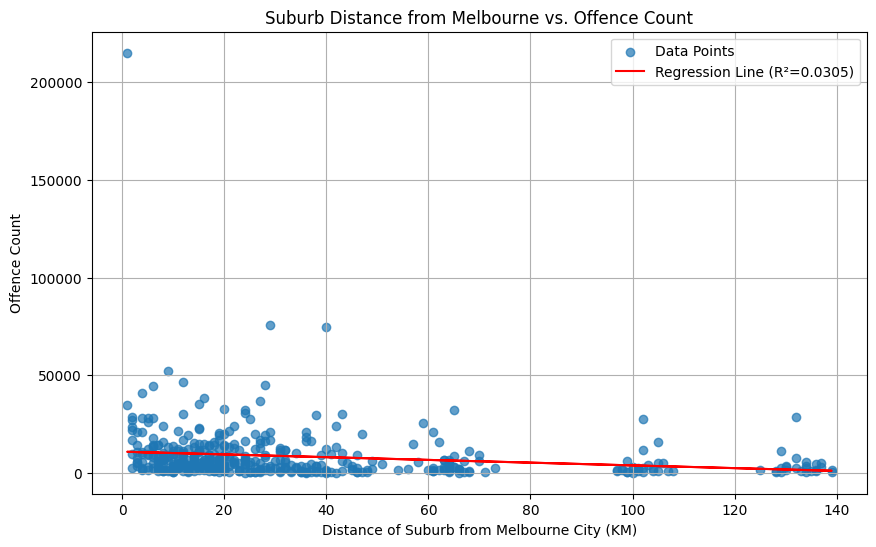

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.linear_model import LinearRegression
import numpy as np

def suburb_distance_from_city_vs_offence_count():
    
    cm = pd.read_csv("imputed_data_communities_new.csv")
    cm["Type"] = cm["Community Name"].apply(extract_type)

    suburbs_df = cm[cm["Type"] == "Suburb"].copy()

    suburb_offences_df = pd.read_excel('LGA Offences.xlsx', sheet_name='Table 03')

    suburbs_df['Community Name'] = suburbs_df['Community Name'].str.replace(r' \((Suburb|suburb)\)', '', regex=True).str.strip().str.lower()
    suburb_offences_df['Suburb/Town Name'] = suburb_offences_df['Suburb/Town Name'].str.strip().str.lower()

    suburb_offenses_grouped = suburb_offences_df.groupby('Suburb/Town Name')['Offence Count'].sum().reset_index()

    suburb = []
    distance_list = []
    categorization = []

    # Create data for suburbs and their distances from Melbourne
    for index, suburbs in suburbs_df.iterrows():
        location = suburbs["Location"]
        distance = int(extract_distance(location))
        
        # Categorize the suburb based on the distance
        if distance <= 20:
            category = 'Urban'
        elif distance >= 20 and distance <= 40:
            category = 'Suburban'
        else:
            category = 'Rural'

        suburb.append(suburbs["Community Name"])
        distance_list.append(distance)
        categorization.append(category)

    distance_df = pd.DataFrame({
        "Community Name": suburb,
        "Distance": distance_list,
        "Category": categorization
    })


    distance_df['Community Name'] = distance_df['Community Name'].str.strip().str.lower()
    suburb_offenses_grouped['Suburb/Town Name'] = suburb_offenses_grouped['Suburb/Town Name'].str.strip().str.lower()

    merged_df = pd.merge(distance_df, suburb_offenses_grouped, left_on='Community Name', right_on='Suburb/Town Name', how='inner')

    merged_df = merged_df.drop(columns=['Suburb/Town Name'])

    merged_df = merged_df[['Community Name', 'Distance', 'Offence Count', 'Category']]

    #Creating a dataframe for use in unemployment and income analysis by assigning geographical categories for each Suburb
    merged_df.to_csv('suburb_analysis.csv', index=False)

    X = merged_df[['Distance']].values
    y = merged_df['Offence Count'].values

    reg = LinearRegression().fit(X, y)
    regression_line = reg.predict(X)
    r_squared = reg.score(X, y)

    plt.figure(figsize=(10, 6))
    plt.scatter(merged_df["Distance"], merged_df['Offence Count'], alpha=0.7, label='Data Points')
    plt.plot(merged_df["Distance"], regression_line, color='red', label=f'Regression Line (R²={r_squared:.4f})')

    plt.title('Suburb Distance from Melbourne vs. Offence Count')
    plt.xlabel('Distance of Suburb from Melbourne City (KM)')
    plt.ylabel('Offence Count')
    plt.legend()
    plt.grid(True)
    plt.show()

def extract_type(name):
    pattern_town = r'\(Suburb|suburb\)'
    if re.findall(pattern_town, name):
        return "Suburb"

def extract_distance(sentence):
    pattern = r'(\d+)km'
    var = re.search(pattern, sentence)
    if var:
        return var.group(1)

suburb_distance_from_city_vs_offence_count()
